**Gated Recurrent Unit** was chosen because it can effectively capture dependencies in sequential data like stock prices. It has a simplified structure (fewer parameters compared to LSTM for example), which helps in reducing training time and the risk of overfitting. So it's a very practical choice for financial time series forecasting.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#loading
data = pd.read_csv("../GOOGL_stock_data.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

# Scale the Close prices
scaler = MinMaxScaler()
data["Close_scaled"] = scaler.fit_transform(data[["Close"]])

# Define sequence length
seq_length = 60  # Look-back period

# Create sequences for GRU
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

# Split
train_split_date = "2022-01-01"
train_data = data[data["Date"] < train_split_date]["Close_scaled"].values
test_data = data[data["Date"] >= train_split_date]["Close_scaled"].values

train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor([s[0] for s in train_sequences], dtype=torch.float32)
y_train = torch.tensor([s[1] for s in train_sequences], dtype=torch.float32)
X_test = torch.tensor([s[0] for s in test_sequences], dtype=torch.float32)
y_test = torch.tensor([s[1] for s in test_sequences], dtype=torch.float32)

# Reshape for GRU input (batch_size, seq_length, input_size)
X_train = X_train.view(X_train.shape[0], seq_length, 1)
X_test = X_test.view(X_test.shape[0], seq_length, 1)


C:\Users\siwma\AppData\Local\Temp\ipykernel_26356\1582803349.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train = torch.tensor([s[0] for s in train_sequences], dtype=torch.float32)


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.gru(x)  #output
        out = self.fc(out[:, -1, :])  # Fully connected layer
        return out


In [4]:
# Initializing
model = GRUModel()

#loss function, optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1/50, Loss: 0.03425714746117592
Epoch 2/50, Loss: 0.030530983582139015
Epoch 3/50, Loss: 0.02946758083999157
Epoch 4/50, Loss: 0.028980756178498268
Epoch 5/50, Loss: 0.027992095798254013
Epoch 6/50, Loss: 0.026476744562387466
Epoch 7/50, Loss: 0.02490607276558876
Epoch 8/50, Loss: 0.0236671045422554
Epoch 9/50, Loss: 0.022675128653645515
Epoch 10/50, Loss: 0.021712448447942734
Epoch 11/50, Loss: 0.020496396347880363
Epoch 12/50, Loss: 0.01925031840801239
Epoch 13/50, Loss: 0.01773403398692608
Epoch 14/50, Loss: 0.01626785658299923
Epoch 15/50, Loss: 0.014948577620089054
Epoch 16/50, Loss: 0.013651971705257893
Epoch 17/50, Loss: 0.012199698016047478
Epoch 18/50, Loss: 0.010531422682106495
Epoch 19/50, Loss: 0.008845362812280655
Epoch 20/50, Loss: 0.007383926305919886
Epoch 21/50, Loss: 0.005785878747701645
Epoch 22/50, Loss: 0.004252217710018158
Epoch 23/50, Loss: 0.002750309882685542
Epoch 24/50, Loss: 0.0014880294911563396
Epoch 25/50, Loss: 0.000767005025409162
Epoch 26/50, Los

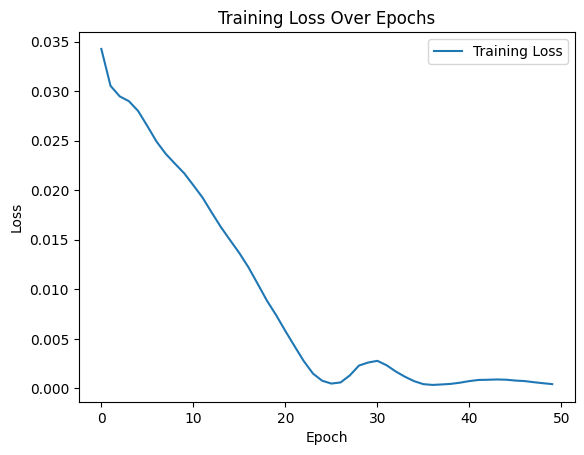

In [5]:
# Training
epochs = 50
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred.view(-1), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Plot training loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


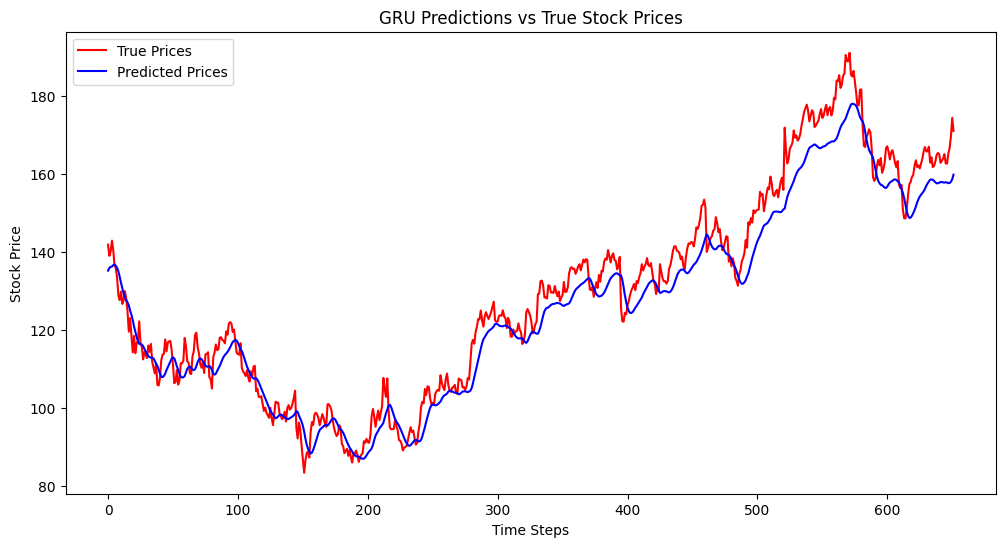

Model saved.


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test).view(-1).numpy()
    y_test_np = y_test.numpy()

# Invert scaling for predictions and true values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_np = scaler.inverse_transform(y_test_np.reshape(-1, 1))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label="True Prices", color="red")
plt.plot(y_pred, label="Predicted Prices", color="blue")
plt.title("GRU Predictions vs True Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Saving the model
torch.save(model.state_dict(), "gru_model.pth")
print("Model saved.")


GRU's model performance is very strong when it comes to stock predicting!!